In [1]:
import os
import tensorflow as tf
import os
import glob
import time
import pickle
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.models import Model

from mtcnn import MTCNN
import matplotlib.pyplot as plt

In [2]:
MAX_FACES = 10

def detections_to_tensors(detections):
    """
    Convert a list of detection dictionaries to separate tensors for
    confidences, bounding boxes, and landmarks.
    
    Args:
    - detections: A list of dictionaries, each containing 'confidence', 'box', and 'keypoints'
    
    Returns:
    - A tuple of tensors: (confidences_tensor, bounding_boxes_tensor, landmarks_tensor)
    """
    # print(f"detections: {detections}")
    confidences = []
    bounding_boxes = []
    landmarks = []
    
    # for detection in detections:

    len_detections = len(detections)
    
    for i in range(MAX_FACES):
        if i >= len_detections:
            confidences.append(0.0)
            bounding_boxes.append([0, 0, 0, 0])
            landmarks.append([0.0] * 10)
        elif detections[i] == None:
            confidences.append(0.0)
            bounding_boxes.append([0, 0, 0, 0])
            landmarks.append([0.0] * 10)
        else:
            detection = detections[i]

            # Extract confidence
            confidences.append(detection['confidence'])
        
            # Extract bounding box
            bounding_boxes.append(detection['box'])
            
            # Extract and flatten landmarks
            kp = detection['keypoints']
            landmarks_flattened = [
                kp['left_eye'][0], kp['left_eye'][1],
                kp['right_eye'][0], kp['right_eye'][1],
                kp['nose'][0], kp['nose'][1],
                kp['mouth_left'][0], kp['mouth_left'][1],
                kp['mouth_right'][0], kp['mouth_right'][1],
            ]
            landmarks.append(landmarks_flattened)

    # Convert lists to tensors
    confidences_tensor = tf.convert_to_tensor(confidences, dtype=tf.float32)
    bounding_boxes_tensor = tf.convert_to_tensor(bounding_boxes, dtype=tf.float32)
    landmarks_tensor = tf.convert_to_tensor(landmarks, dtype=tf.float32)

    return confidences_tensor, bounding_boxes_tensor, landmarks_tensor


batch_detections: [{'box': [120, 54, 11, 17], 'confidence': 0.9452680349349976, 'keypoints': {'left_eye': (121, 59), 'right_eye': (126, 60), 'nose': (122, 63), 'mouth_left': (120, 67), 'mouth_right': (125, 68)}}, {'box': [51, 40, 13, 18], 'confidence': 0.9106280207633972, 'keypoints': {'left_eye': (52, 45), 'right_eye': (58, 45), 'nose': (53, 48), 'mouth_left': (52, 53), 'mouth_right': (57, 53)}}]

detection: {'box': [120, 54, 11, 17], 'confidence': 0.9452680349349976, 'keypoints': {'left_eye': (121, 59), 'right_eye': (126, 60), 'nose': (122, 63), 'mouth_left': (120, 67), 'mouth_right': (125, 68)}}



In [3]:
def get_pkl_name(file_name_tensor, dir_tensor):
    dir = dir_tensor.numpy().decode('utf-8')

    label_dir = "/data/" + dir + '_labels/'
    file_name_str = file_name_tensor.numpy().decode('utf-8')
    base_path = os.path.splitext(file_name_str)[0]
    path_parts = base_path.split(os.sep)
    cwd = os.getcwd()
    parts = cwd + label_dir + path_parts[-1]
    pkl_path = parts + '.pkl'
    normalized_path = os.path.normpath(pkl_path)
    return normalized_path
    
def get_confidences_from_pickle(filename, dir):
    pkl_path = get_pkl_name(filename, dir)
    # Load the pickle file
    if os.path.exists(pkl_path):
        # Read labels from pickle file
        with open(pkl_path, 'rb') as f:
            labels = pickle.load(f)
        # Combine confidences, bounding boxes, and landmarks into a single tensor
        confidences, boxes, landmarks = detections_to_tensors(labels)
        return confidences
    else:
        # Return default labels if pickle file does not exist   
        return tf.zeros([MAX_FACES])
    
def get_bounding_boxes_from_pickle(filename, dir):
    pkl_path = get_pkl_name(filename, dir)

    # Load the pickle file
    if os.path.exists(pkl_path):
        # Read labels from pickle file
        with open(pkl_path, 'rb') as f:
            labels = pickle.load(f)
        # Combine confidences, bounding boxes, and landmarks into a single tensor
        confidences, boxes, landmarks = detections_to_tensors(labels)
        return boxes
    else:
        # Return default labels if pickle file does not exist   
        return tf.zeros([MAX_FACES, 4])
    
def get_landmarks_from_pickle(filename, dir):
    pkl_path = get_pkl_name(filename, dir)
    
    # Load the pickle file
    if os.path.exists(pkl_path):
        # Read labels from pickle file
        with open(pkl_path, 'rb') as f:
            labels = pickle.load(f)
        # Combine confidences, bounding boxes, and landmarks into a single tensor
        confidences, boxes, landmarks = detections_to_tensors(labels)
        return landmarks
    else:
        # Return default labels if pickle file does not exist   
        return tf.zeros([MAX_FACES, 10])


def parse_and_predict(filename, teacher_model=None, split = 'train'):
    """
    Parse images and use the teacher model to generate labels.
    """
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)  # Normalize the image
    if teacher_model is not None:
        confidences = tf.py_function(func=get_confidences_from_pickle,
                                inp=[filename, split],
                                Tout=tf.float32)
        bounding_boxes = tf.py_function(func=get_bounding_boxes_from_pickle,
                                inp=[filename, split],
                                Tout=tf.float32)
        landmarks = tf.py_function(func=get_landmarks_from_pickle,
                                inp=[filename, split],
                                Tout=tf.float32)
                                
        labels = (confidences, bounding_boxes, landmarks)

        return image, labels


    return image, {'confidences': tf.zeros([MAX_FACES]), 'bounding_boxes': tf.zeros([MAX_FACES, 4]), 'landmarks': tf.zeros([MAX_FACES, 10])}


def load_wider_face_dataset(base_directory, split='train', teacher_model=None):
    assert split in ['train', 'test', 'val'], "Split must be 'train', 'test', or 'val'"
    split_directory = os.path.join(base_directory, split)
    
    # Recursively find JPEG images in subfolders
    image_paths = glob.glob(os.path.join(split_directory, '**', '*.jpg'), recursive=True)
    
    if not teacher_model:
        raise ValueError("A teacher model must be provided for label creation")

    # Create a dataset of image paths
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    # Map each image to the parse_and_predict function
    image_dataset = image_dataset.map(lambda x: parse_and_predict(x, teacher_model, split),
                                      num_parallel_calls=tf.data.AUTOTUNE)

    return image_dataset.batch(64).prefetch(tf.data.AUTOTUNE)



In [4]:
base_directory = 'C:/Users/bridg/tensorflow_datasets/my_wider_face'
teacher_model = MTCNN()

train_dataset = load_wider_face_dataset(base_directory, 'train', teacher_model)

test_dataset = load_wider_face_dataset(base_directory, 'test', teacher_model)

val_dataset = load_wider_face_dataset(base_directory, 'val', teacher_model)



In [5]:
data = train_dataset.take(1)
print(f"data: {data}")
for image, label in data:
    # print(f"thing: {thing}")
    print(f"image: {image}")
    print(f"label: {label}")

data: <_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)))>
image: [[[[8.14461136e+01 8.24461136e+01 7.64461136e+01]
   [8.19856491e+01 8.29856491e+01 7.69856491e+01]
   [8.10698318e+01 8.20698318e+01 7.60698318e+01]
   ...
   [2.48000000e+02 2.32000000e+02 2.16000000e+02]
   [2.48669586e+02 2.32669586e+02 2.16669586e+02]
   [2.44669220e+02 2.28669220e+02 2.12669220e+02]]

  [[8.34955368e+01 8.44955368e+01 7.84955368e+01]
   [7.92662659e+01 8.02662659e+01 7.42662659e+01]
   [8.00000000e+01 8.10000000e+01 7.50000000e+01]
   ...
   [2.45933029e+02 2.29933029e+02 2.13933029e+02]
   [2.43714233e+02 2.27714233e+02 2.11714233e+02]
   [2.39728226e+02 2.23728226e+02 2.07728226e+02]]

  [[8.46189423e+01 8.56189423e+01 7.96189423e+01]
   [7.67767868e+01 7.77767868e+01 7.17767868e+

In [6]:
tf.__version__

'2.15.0'

In [7]:
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# set a max number of faces
# trim any faces that are below a conficence threshold
# refactor how mtcnn data is read to grab n most confident faces
   # set the confidences and info to zero for faces that are below the threshold

# Freeze the convolutional base to prevent its weights from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for face and landmark detection
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# Output layer for face detection (assuming binary classification: face/no face)
confidences = Dense(MAX_FACES, activation='sigmoid', name='confidences')(x)

# Predict bounding boxes for each detection
bounding_boxes_dense = Dense(MAX_FACES * 4, activation='linear', name='bounding_boxes_dense')(x)
bounding_boxes = Reshape((MAX_FACES, 4), name='bounding_boxes')(bounding_boxes_dense)

# Predict landmarks for each detection
landmarks_dense = Dense(MAX_FACES * 10, activation='linear', name='landmarks_dense')(x)
landmarks = Reshape((MAX_FACES, 10), name='landmarks')(landmarks_dense)

model = Model(inputs=base_model.input, outputs=[confidences, bounding_boxes, landmarks])


In [8]:
# def show_images(dataset, num_images=9):
#     plt.figure(figsize=(10, 10))
#     for images in dataset.take(1):  # Take one batch from the dataset
#         for i in range(num_images):
#             ax = plt.subplot(3, 3, i + 1)
#             plt.imshow(images[i].numpy().astype("uint8"))
#             plt.axis("off")
#     plt.show()

# # Assuming `dataset` is your TensorFlow dataset
# show_images(train_dataset)


In [10]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'confidences': MeanSquaredError(),
        'bounding_boxes': MeanSquaredError(),
        'landmarks': MeanSquaredError()
    },
    loss_weights={
        'confidences': 1000.0,   # Adjust these weights to balance the contribution of each loss
        'bounding_boxes': 1.0,
        'landmarks': 1.0
    },
    metrics={
        'confidences': ['mse'],
        'bounding_boxes': ['mse'],
        'landmarks': ['mse']
    }
)

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    validation_freq=1
)


    

Epoch 1/100
202/202 [==============================] - 205s 975ms/step - loss: 46073.0391 - confidences_loss: 0.1905 - bounding_boxes_loss: 14754.4463 - landmarks_loss: 31128.1113 - confidences_mse: 0.1905 - bounding_boxes_mse: 14754.4443 - landmarks_mse: 31128.0996 - val_loss: 67956.4219 - val_confidences_loss: 0.2242 - val_bounding_boxes_loss: 21850.1270 - val_landmarks_loss: 45882.1133 - val_confidences_mse: 0.2242 - val_bounding_boxes_mse: 21850.1230 - val_landmarks_mse: 45882.1094
Epoch 2/100
202/202 [==============================] - 173s 854ms/step - loss: 45071.2461 - confidences_loss: 0.1664 - bounding_boxes_loss: 14424.5166 - landmarks_loss: 30480.3164 - confidences_mse: 0.1664 - bounding_boxes_mse: 14424.5156 - landmarks_mse: 30480.3066 - val_loss: 63647.3867 - val_confidences_loss: 0.1733 - val_bounding_boxes_loss: 20432.4219 - val_landmarks_loss: 43041.6250 - val_confidences_mse: 0.1733 - val_bounding_boxes_mse: 20432.4199 - val_landmarks_mse: 43041.6250
Epoch 3/100
202/20

In [11]:
test_loss, confidence_loss, bb_loss, l_loss, c_mse, bb_mse, l_mse = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")


252/252 [==============================] - 208s 825ms/step - loss: 47300.3359 - confidences_loss: 0.1365 - bounding_boxes_loss: 15131.1943 - landmarks_loss: 32032.6348 - confidences_mse: 0.1365 - bounding_boxes_mse: 15131.1953 - landmarks_mse: 32032.6445
Test Loss: 47300.3359375


history: {'loss': [46073.0390625, 45071.24609375, 43552.67578125, 42629.5703125, 41921.4375, 41304.8125, 40783.5546875, 40307.1171875, 39829.82421875, 39480.10546875, 39116.87890625, 38748.234375, 38425.29296875, 38101.6484375, 37757.39453125, 37431.15234375, 37120.9921875, 36775.19140625, 36464.7890625, 36144.16796875, 35825.93359375, 35489.96875, 35156.27734375, 34808.171875, 34459.3671875, 34091.3125, 33731.359375, 33365.0078125, 32972.5234375, 32578.22265625, 32203.2265625, 31817.267578125, 31416.638671875, 31037.01953125, 30604.40234375, 30192.72265625, 29773.2890625, 29346.78515625, 28929.560546875, 28500.109375, 28076.8984375, 27653.197265625, 27220.8515625, 26792.578125, 26358.021484375, 25928.865234375, 25500.337890625, 25075.115234375, 24648.23828125, 24222.22265625, 23797.3515625, 23398.29296875, 23020.642578125, 22601.853515625, 22192.720703125, 21760.830078125, 21365.490234375, 20955.384765625, 20559.275390625, 20157.98046875, 19773.3984375, 19390.400390625, 19028.72460937

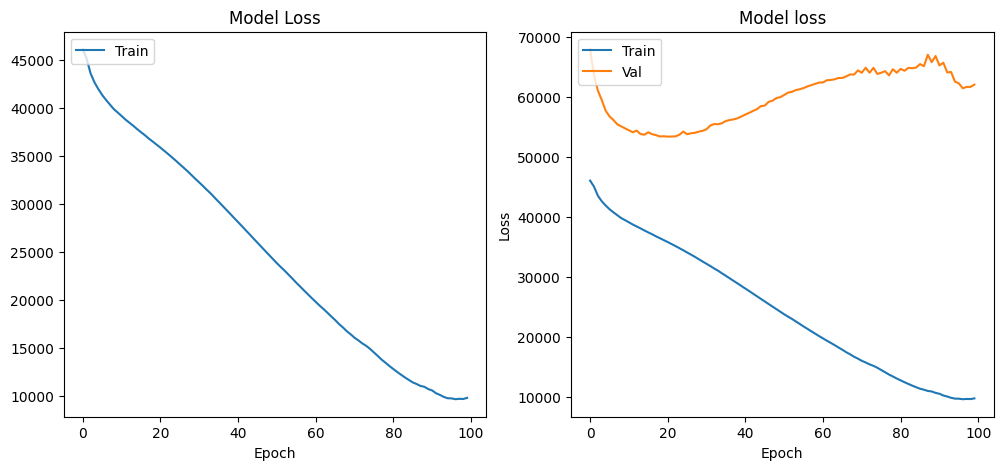

In [12]:
import matplotlib.pyplot as plt

print(f"history: {history.history}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()


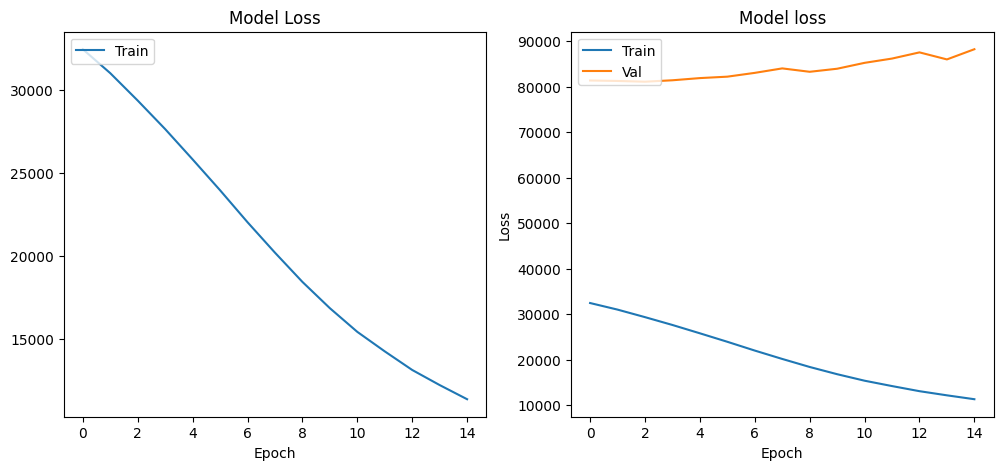


In [13]:
from tensorflow.keras.models import load_model
model.save('lean-mtcnn100.keras')

try:
    loaded_model = load_model('lean-mtcnn.keras')
    print("Model loaded successfully")
except Exception as e:
    print("Failed to load model:", e)

Model loaded successfully


In [ ]:
# try:
#     loaded_model = load_model('lean-mtcnn2.keras')
#     print("Model loaded successfully")
# except Exception as e:
#     print("Failed to load model:", e)

Failed to load model: No file or directory found at lean-mtcnn2.keras


In [ ]:
# loaded_model = load_model('lean-mtcnn.keras')
# print("Model loaded successfully")

Model loaded successfully


In [ ]:
# import h5py

# try:
#     with h5py.File('C:/Users/bridg/Desktop/Sandbox/Rooster/rooster-deepface/deepface/detectors/lean-mtcnn.h5', 'r') as file:
#         print("File can be opened. Contents:", list(file.keys()))
# except Exception as e:
#     print("Error opening file:", e)


Error opening file: [Errno 2] Unable to open file (unable to open file: name = 'C:/Users/bridg/Desktop/Sandbox/Rooster/rooster-deepface/deepface/detectors/lean-mtcnn.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [ ]:
# model.summary()

detections: [{'box': [0, 0, 0, 0], 'confidence': 0.6748742461204529, 'keypoints': {'left_eye': (-0.73534316, 1.0557722), 'right_eye': (0.52684826, 0.087934226), 'nose': (-3.246008, 1.0227318), 'mouth_left': (-0.070850015, -2.3160443), 'mouth_right': (-0.30880076, -1.1930287)}}, {'box': [0, 0, 0, 0], 'confidence': 0.662733256816864, 'keypoints': {'left_eye': (-0.46789718, 1.1963675), 'right_eye': (2.265353, -0.6215133), 'nose': (-0.5917515, 1.2513131), 'mouth_left': (0.2775367, -1.4230711), 'mouth_right': (1.2971957, -0.44156244)}}, {'box': [0, 0, 0, 0], 'confidence': 0.7612593173980713, 'keypoints': {'left_eye': (0.02128604, -0.1444282), 'right_eye': (0.9780227, -0.062327206), 'nose': (-0.7947538, -0.24396026), 'mouth_left': (-0.80730915, -0.39987165), 'mouth_right': (-0.243312, -0.40480956)}}, {'box': [0, 0, 0, 0], 'confidence': 0.7261316776275635, 'keypoints': {'left_eye': (0.19468048, -0.12398183), 'right_eye': (0.3937503, 0.80306935), 'nose': (-2.1229439, 1.3268812), 'mouth_left': (0.37262142, -1.9344918), 'mouth_right': (-0.009756461, -1.6687906)}}, {'box': [0, 0, 0, 0], 'confidence': 0.6112657189369202, 'keypoints': {'left_eye': (-1.4376838, -0.13405369), 'right_eye': (0.9454672, -1.0054946), 'nose': (-1.2796795, 0.7237004), 'mouth_left': (0.17286426, -1.6581006), 'mouth_right': (-0.051362723, -1.3805331)}}, {'box': [0, 0, 0, 0], 'confidence': 0.43956613540649414, 'keypoints': {'left_eye': (0.25797448, 0.10887772), 'right_eye': (1.742039, 0.047320604), 'nose': (-2.6878638, 1.2664157), 'mouth_left': (-0.6220403, -0.83493066), 'mouth_right': (0.64588857, 0.46361288)}}, {'box': [0, 0, 0, 0], 'confidence': 0.45596566796302795, 'keypoints': {'left_eye': (-0.48110017, -0.054014698), 'right_eye': (0.81094515, 0.20306033), 'nose': (-1.3471062, 1.043869), 'mouth_left': (-0.45052552, -0.91372937), 'mouth_right': (0.38716, 0.31470937)}}, {'box': [0, 0, 0, 0], 'confidence': 0.3327430784702301, 'keypoints': {'left_eye': (-0.8909421, -0.10495494), 'right_eye': (0.78482074, 0.22628881), 'nose': (-1.6374907, 1.1686583), 'mouth_left': (-0.23000596, -2.0365424), 'mouth_right': (0.8789638, -1.7195067)}}, {'box': [0, 0, 0, 0], 'confidence': 0.6887228488922119, 'keypoints': {'left_eye': (-1.0079868, -0.5448346), 'right_eye': (0.47385538, 0.15579048), 'nose': (-2.1194272, 0.955676), 'mouth_left': (1.0999314, -1.1255065), 'mouth_right': (-0.1230492, -1.2754079)}}, {'box': [0, 0, 0, 0], 'confidence': 0.26138707995414734, 'keypoints': {'left_eye': (-2.0817835, 0.8285319), 'right_eye': (2.9650826, -0.3966746), 'nose': (-1.7730532, -0.1268357), 'mouth_left': (-0.38797796, -2.1397014), 'mouth_right': (0.32318836, -1.3868986)}}, {'box': [0, 0, 0, 0], 'confidence': 0.44208064675331116, 'keypoints': {'left_eye': (-1.4223311, 0.5183261), 'right_eye': (0.92046547, 0.36272493), 'nose': (-2.7218766, 0.8806597), 'mouth_left': (-0.5534946, -1.6414999), 'mouth_right': (0.059157312, -0.39896873)}}, {'box': [0, 0, 0, 0], 'confidence': 0.6162046194076538, 'keypoints': {'left_eye': (-0.7164855, -0.3229618), 'right_eye': (1.4644511, 1.094023), 'nose': (-1.5458885, 1.6753731), 'mouth_left': (0.7595, -1.9355742), 'mouth_right': (0.60619366, -1.6566324)}}, {'box': [0, 0, 0, 0], 'confidence': 0.5007038712501526, 'keypoints': {'left_eye': (-0.8981524, 0.2851976), 'right_eye': (2.0749166, -0.25473645), 'nose': (-2.055313, 0.47512257), 'mouth_left': (1.4844327, -1.8432792), 'mouth_right': (0.45787084, -0.9326553)}}, {'box': [0, 0, 0, 0], 'confidence': 0.6677223443984985, 'keypoints': {'left_eye': (0.26903564, 0.7264953), 'right_eye': (2.31631, -0.20283666), 'nose': (-2.39993, 0.3170562), 'mouth_left': (0.31730622, -2.4194305), 'mouth_right': (-0.6484506, -1.0925173)}}, {'box': [0, 0, 0, 0], 'confidence': 0.6510516405105591, 'keypoints': {'left_eye': (0.4056281, -0.46656206), 'right_eye': (0.69371736, 0.6295694), 'nose': (-1.0539335, 1.3557016), 'mouth_left': (1.024978, -1.1571667), 'mouth_right': (0.27583224, -2.5201042)}}, {'box': [0, 0, 0, 0], 'confidence': 0.7634016871452332, 'keypoints': {'left_eye': (-0.75844675, 1.5011079), 'right_eye': (1.3022864, 0.034379803), 'nose': (-2.9678924, 0.88230073), 'mouth_left': (-0.18527794, -2.5490048), 'mouth_right': (-1.0788337, -1.2654924)}}, {'box': [0, 0, 0, 0], 'confidence': 0.8083810210227966, 'keypoints': {'left_eye': (0.12408441, 0.3159696), 'right_eye': (1.3021337, -0.24238002), 'nose': (-1.8894472, 0.57253164), 'mouth_left': (-0.19124562, -1.569947), 'mouth_right': (1.5067283, -2.5788105)}}, {'box': [0, 0, 0, 0], 'confidence': 0.22409279644489288, 'keypoints': {'left_eye': (-0.7106621, 0.31891042), 'right_eye': (2.041935, 0.123496056), 'nose': (-0.604337, 0.05501657), 'mouth_left': (-0.46236682, -0.93050236), 'mouth_right': (-0.5908302, -0.50541604)}}, {'box': [0, 0, 0, 0], 'confidence': 0.6429218649864197, 'keypoints': {'left_eye': (0.8314836, 0.5336419), 'right_eye': (0.994622, -0.55376697), 'nose': (-1.3113993, 1.2257055), 'mouth_left': (0.20948464, -1.9082013), 'mouth_right': (-0.9077283, -0.65188754)}}, {'box': [0, 0, 0, 0], 'confidence': 0.8969323039054871, 'keypoints': {'left_eye': (-0.3491745, -0.77068746), 'right_eye': (0.9141724, 1.1773255), 'nose': (-1.7386501, -0.014859706), 'mouth_left': (-0.6711997, -1.1837105), 'mouth_right': (-0.03721135, -1.170072)}}, {'box': [0, 0, 0, 0], 'confidence': 0.7750704288482666, 'keypoints': {'left_eye': (-0.35558227, 3.3539774), 'right_eye': (1.1430913, -0.8557833), 'nose': (-0.5160624, 0.5252401), 'mouth_left': (1.4499307, -0.18910882), 'mouth_right': (-0.93902135, -0.7960827)}}, {'box': [0, 0, 0, 0], 'confidence': 0.8036332726478577, 'keypoints': {'left_eye': (-0.57090366, 0.19525385), 'right_eye': (1.4522698, 0.53823686), 'nose': (-2.520535, 0.7806097), 'mouth_left': (-0.18835843, -2.103738), 'mouth_right': (-0.12026468, -1.3040837)}}, {'box': [0, 0, 0, 0], 'confidence': 0.7937236428260803, 'keypoints': {'left_eye': (-0.1102094, -0.13833255), 'right_eye': (0.16710642, 0.64867634), 'nose': (-1.1720443, 0.01630336), 'mouth_left': (-0.02336435, -1.401716), 'mouth_right': (0.79992783, -1.1465005)}}, {'box': [0, 0, 0, 0], 'confidence': 0.5418329834938049, 'keypoints': {'left_eye': (0.3170822, 0.8031453), 'right_eye': (0.122058064, 0.4389605), 'nose': (-0.75579894, 1.3108217), 'mouth_left': (-1.5569513, -0.37622035), 'mouth_right': (0.6614735, -0.579587)}}, {'box': [0, 0, 0, 0], 'confidence': 0.4066491723060608, 'keypoints': {'left_eye': (-1.342586, 0.24617955), 'right_eye': (0.59812474, 1.2999786), 'nose': (-1.0304201, 0.7791197), 'mouth_left': (0.1895448, -0.6043046), 'mouth_right': (0.23198086, -1.0792239)}}, {'box': [0, 0, 0, 0], 'confidence': 0.6315093040466309, 'keypoints': {'left_eye': (-0.37820798, 0.30032268), 'right_eye': (-0.36450517, 0.16434371), 'nose': (-2.6078386, 0.9522995), 'mouth_left': (0.2733035, -2.0981436), 'mouth_right': (-0.8825002, -2.2394173)}}, {'box': [0, 0, 0, 0], 'confidence': 0.7679756283760071, 'keypoints': {'left_eye': (-0.33176193, -0.47868887), 'right_eye': (0.97607106, 0.4909075), 'nose': (-1.8264654, 1.1663303), 'mouth_left': (0.40391463, -0.93893725), 'mouth_right': (0.09386648, -0.78133535)}}, {'box': [0, 0, 0, 0], 'confidence': 0.7475014925003052, 'keypoints': {'left_eye': (-0.3774311, 0.7491859), 'right_eye': (0.17327793, 0.40230832), 'nose': (-1.2746692, -0.17657539), 'mouth_left': (0.14843279, -0.39118445), 'mouth_right': (0.778028, -0.34455544)}}, {'box': [0, 0, 0, 0], 'confidence': 0.4190661609172821, 'keypoints': {'left_eye': (-0.19434883, 0.16757837), 'right_eye': (1.592175, -0.61957973), 'nose': (-1.334296, 0.31065306), 'mouth_left': (-0.35070005, -1.1454306), 'mouth_right': (-0.43045896, -0.20537475)}}, {'box': [0, 0, 0, 0], 'confidence': 0.5351845622062683, 'keypoints': {'left_eye': (0.8510463, 0.9252754), 'right_eye': (0.62585545, -0.27070066), 'nose': (-1.6858616, 0.35231534), 'mouth_left': (-0.21385603, -1.3673733), 'mouth_right': (0.38269535, -0.80226666)}}, {'box': [0, 0, 0, 0], 'confidence': 0.4229130446910858, 'keypoints': {'left_eye': (-0.13112305, -0.53981864), 'right_eye': (0.90451014, 0.10645044), 'nose': (-3.051505, 0.60885894), 'mouth_left': (-1.2859052, -1.5442549), 'mouth_right': (-0.57167697, 0.5641434)}}, {'box': [0, 0, 0, 0], 'confidence': 0.8828781247138977, 'keypoints': {'left_eye': (-0.18554488, -1.1352165), 'right_eye': (1.1226485, 1.0341074), 'nose': (-2.974544, 1.0071846), 'mouth_left': (-0.60380226, -1.4423974), 'mouth_right': (0.17357188, -0.8182271)}}]


labels: [[], [{'box': [24, 30, 18, 27], 'confidence': 0.9997275471687317, 'keypoints': {'left_eye': (30, 40), 'right_eye': (38, 42), 'nose': (34, 46), 'mouth_left': (28, 49), 'mouth_right': (37, 51)}}, {'box': [145, 42, 20, 30], 'confidence': 0.9990147352218628, 'keypoints': {'left_eye': (151, 53), 'right_eye': (160, 54), 'nose': (154, 60), 'mouth_left': (150, 65), 'mouth_right': (157, 66)}}, {'box': [73, 47, 19, 28], 'confidence': 0.9989433884620667, 'keypoints': {'left_eye': (80, 57), 'right_eye': (88, 59), 'nose': (84, 64), 'mouth_left': (79, 67), 'mouth_right': (87, 69)}}, {'box': [115, 52, 17, 28], 'confidence': 0.9985287189483643, 'keypoints': {'left_eye': (118, 62), 'right_eye': (126, 62), 'nose': (121, 67), 'mouth_left': (118, 72), 'mouth_right': (127, 72)}}, {'box': [178, 53, 17, 26], 'confidence': 0.9978204965591431, 'keypoints': {'left_eye': (181, 62), 'right_eye': (190, 63), 'nose': (185, 68), 'mouth_left': (181, 72), 'mouth_right': (189, 73)}}], [{'box': [81, 43, 17, 29], 'confidence': 0.973102331161499, 'keypoints': {'left_eye': (91, 53), 'right_eye': (97, 52), 'nose': (97, 59), 'mouth_left': (92, 65), 'mouth_right': (96, 65)}}, {'box': [129, 16, 20, 34], 'confidence': 0.9348683953285217, 'keypoints': {'left_eye': (133, 29), 'right_eye': (140, 26), 'nose': (136, 35), 'mouth_left': (138, 44), 'mouth_right': (142, 42)}}], [], [], [{'box': [92, 39, 14, 19], 'confidence': 0.998066246509552, 'keypoints': {'left_eye': (95, 45), 'right_eye': (103, 45), 'nose': (99, 51), 'mouth_left': (96, 54), 'mouth_right': (103, 53)}}, {'box': [179, 35, 15, 20], 'confidence': 0.9970511198043823, 'keypoints': {'left_eye': (182, 40), 'right_eye': (190, 40), 'nose': (185, 46), 'mouth_left': (183, 49), 'mouth_right': (190, 49)}}, {'box': [58, 40, 15, 23], 'confidence': 0.9963812828063965, 'keypoints': {'left_eye': (62, 49), 'right_eye': (70, 49), 'nose': (66, 54), 'mouth_left': (62, 57), 'mouth_right': (69, 57)}}, {'box': [29, 49, 14, 22], 'confidence': 0.9856202602386475, 'keypoints': {'left_eye': (34, 56), 'right_eye': (41, 57), 'nose': (38, 63), 'mouth_left': (33, 66), 'mouth_right': (39, 66)}}, {'box': [138, 35, 17, 28], 'confidence': 0.9763843417167664, 'keypoints': {'left_eye': (144, 46), 'right_eye': (152, 47), 'nose': (148, 53), 'mouth_left': (143, 56), 'mouth_right': (150, 57)}}], [], [{'box': [138, 38, 14, 20], 'confidence': 0.9882583022117615, 'keypoints': {'left_eye': (140, 45), 'right_eye': (147, 43), 'nose': (144, 49), 'mouth_left': (142, 53), 'mouth_right': (148, 51)}}, {'box': [35, 28, 15, 25], 'confidence': 0.9718230962753296, 'keypoints': {'left_eye': (39, 37), 'right_eye': (47, 38), 'nose': (43, 43), 'mouth_left': (39, 46), 'mouth_right': (45, 47)}}, {'box': [171, 36, 14, 25], 'confidence': 0.9571990370750427, 'keypoints': {'left_eye': (173, 46), 'right_eye': (180, 45), 'nose': (175, 52), 'mouth_left': (173, 56), 'mouth_right': (179, 55)}}, {'box': [101, 31, 15, 23], 'confidence': 0.942952573299408, 'keypoints': {'left_eye': (104, 39), 'right_eye': (112, 39), 'nose': (108, 45), 'mouth_left': (105, 49), 'mouth_right': (111, 49)}}, {'box': [74, 25, 16, 27], 'confidence': 0.871976375579834, 'keypoints': {'left_eye': (79, 36), 'right_eye': (87, 37), 'nose': (84, 42), 'mouth_left': (79, 46), 'mouth_right': (85, 46)}}], [], [{'box': [122, 45, 7, 11], 'confidence': 0.9735006093978882, 'keypoints': {'left_eye': (124, 50), 'right_eye': (128, 49), 'nose': (126, 52), 'mouth_left': (125, 54), 'mouth_right': (128, 54)}}, {'box': [87, 57, 9, 13], 'confidence': 0.9728569388389587, 'keypoints': {'left_eye': (90, 62), 'right_eye': (95, 63), 'nose': (92, 67), 'mouth_left': (89, 69), 'mouth_right': (93, 69)}}, {'box': [113, 101, 12, 16], 'confidence': 0.862289309501648, 'keypoints': {'left_eye': (116, 106), 'right_eye': (122, 106), 'nose': (119, 109), 'mouth_left': (116, 112), 'mouth_right': (121, 112)}}, {'box': [180, 36, 12, 17], 'confidence': 0.7790029644966125, 'keypoints': {'left_eye': (182, 42), 'right_eye': (186, 41), 'nose': (183, 45), 'mouth_left': (183, 49), 'mouth_right': (187, 48)}}, {'box': [39, 38, 11, 14], 'confidence': 0.7031712532043457, 'keypoints': {'left_eye': (44, 41), 'right_eye': (49, 42), 'nose': (47, 46), 'mouth_left': (43, 48), 'mouth_right': (47, 48)}}], [], [], [], [], [], [], [], [{'box': [12, 58, 22, 32], 'confidence': 0.9999390840530396, 'keypoints': {'left_eye': (23, 70), 'right_eye': (32, 70), 'nose': (31, 78), 'mouth_left': (25, 83), 'mouth_right': (31, 83)}}, {'box': [87, 56, 13, 21], 'confidence': 0.9996486902236938, 'keypoints': {'left_eye': (93, 63), 'right_eye': (99, 64), 'nose': (97, 69), 'mouth_left': (92, 72), 'mouth_right': (97, 72)}}, {'box': [116, 47, 11, 17], 'confidence': 0.9858732223510742, 'keypoints': {'left_eye': (119, 53), 'right_eye': (125, 53), 'nose': (122, 57), 'mouth_left': (120, 61), 'mouth_right': (124, 60)}}, {'box': [191, 43, 9, 13], 'confidence': 0.9697521328926086, 'keypoints': {'left_eye': (192, 49), 'right_eye': (196, 47), 'nose': (194, 51), 'mouth_left': (194, 54), 'mouth_right': (197, 53)}}], [{'box': [91, 113, 8, 10], 'confidence': 0.9931857585906982, 'keypoints': {'left_eye': (92, 116), 'right_eye': (97, 115), 'nose': (95, 118), 'mouth_left': (93, 121), 'mouth_right': (97, 120)}}], [], [], [], [{'box': [208, 54, 17, 18], 'confidence': 0.997380793094635, 'keypoints': {'left_eye': (211, 60), 'right_eye': (218, 59), 'nose': (213, 64), 'mouth_left': (212, 68), 'mouth_right': (218, 68)}}, {'box': [138, 27, 25, 28], 'confidence': 0.9966952800750732, 'keypoints': {'left_eye': (141, 37), 'right_eye': (150, 38), 'nose': (141, 43), 'mouth_left': (139, 49), 'mouth_right': (146, 49)}}, {'box': [34, 38, 18, 19], 'confidence': 0.9934418201446533, 'keypoints': {'left_eye': (36, 45), 'right_eye': (43, 45), 'nose': (37, 50), 'mouth_left': (37, 55), 'mouth_right': (43, 54)}}], [{'box': [29, 12, 37, 54], 'confidence': 0.9999991655349731, 'keypoints': {'left_eye': (53, 33), 'right_eye': (64, 34), 'nose': (65, 44), 'mouth_left': (51, 51), 'mouth_right': (62, 52)}}, {'box': [159, 23, 31, 50], 'confidence': 0.9999954700469971, 'keypoints': {'left_eye': (162, 42), 'right_eye': (169, 43), 'nose': (159, 53), 'mouth_left': (164, 62), 'mouth_right': (171, 62)}}], [], [], [], [{'box': [82, 60, 43, 70], 'confidence': 0.9998668432235718, 'keypoints': {'left_eye': (112, 88), 'right_eye': (124, 87), 'nose': (129, 98), 'mouth_left': (114, 113), 'mouth_right': (125, 111)}}, {'box': [48, 84, 16, 23], 'confidence': 0.9290136694908142, 'keypoints': {'left_eye': (55, 91), 'right_eye': (62, 91), 'nose': (60, 96), 'mouth_left': (56, 102), 'mouth_right': (61, 102)}}, {'box': [176, 170, 24, 45], 'confidence': 0.8331894278526306, 'keypoints': {'left_eye': (190, 187), 'right_eye': (198, 188), 'nose': (199, 196), 'mouth_left': (191, 206), 'mouth_right': (197, 206)}}], [{'box': [177, 34, 20, 28], 'confidence': 0.9993168115615845, 'keypoints': {'left_eye': (179, 45), 'right_eye': (188, 44), 'nose': (182, 51), 'mouth_left': (181, 56), 'mouth_right': (188, 55)}}, {'box': [9, 46, 19, 26], 'confidence': 0.999021053314209, 'keypoints': {'left_eye': (15, 54), 'right_eye': (24, 55), 'nose': (21, 61), 'mouth_left': (14, 64), 'mouth_right': (23, 64)}}, {'box': [84, 40, 15, 21], 'confidence': 0.998915433883667, 'keypoints': {'left_eye': (90, 48), 'right_eye': (97, 47), 'nose': (95, 53), 'mouth_left': (90, 56), 'mouth_right': (96, 55)}}, {'box': [116, 33, 15, 24], 'confidence': 0.9959874749183655, 'keypoints': {'left_eye': (122, 43), 'right_eye': (129, 43), 'nose': (127, 49), 'mouth_left': (121, 52), 'mouth_right': (127, 52)}}, {'box': [45, 52, 18, 25], 'confidence': 0.9835267663002014, 'keypoints': {'left_eye': (51, 63), 'right_eye': (59, 61), 'nose': (57, 68), 'mouth_left': (51, 72), 'mouth_right': (60, 70)}}, {'box': [145, 40, 18, 23], 'confidence': 0.9813764691352844, 'keypoints': {'left_eye': (146, 51), 'right_eye': (153, 48), 'nose': (149, 55), 'mouth_left': (150, 60), 'mouth_right': (156, 57)}}], [{'box': [85, 60, 51, 65], 'confidence': 0.999955415725708, 'keypoints': {'left_eye': (97, 81), 'right_eye': (121, 84), 'nose': (104, 97), 'mouth_left': (95, 105), 'mouth_right': (118, 109)}}, {'box': [52, 109, 10, 14], 'confidence': 0.8889723420143127, 'keypoints': {'left_eye': (52, 115), 'right_eye': (56, 115), 'nose': (51, 117), 'mouth_left': (52, 121), 'mouth_right': (55, 121)}}], [{'box': [128, 64, 10, 16], 'confidence': 0.9563508033752441, 'keypoints': {'left_eye': (127, 69), 'right_eye': (131, 68), 'nose': (127, 73), 'mouth_left': (129, 77), 'mouth_right': (132, 76)}}, {'box': [198, 72, 10, 19], 'confidence': 0.8957076072692871, 'keypoints': {'left_eye': (198, 79), 'right_eye': (202, 79), 'nose': (197, 83), 'mouth_left': (199, 88), 'mouth_right': (202, 87)}}, {'box': [10, 76, 12, 23], 'confidence': 0.8844919204711914, 'keypoints': {'left_eye': (17, 83), 'right_eye': (21, 83), 'nose': (21, 89), 'mouth_left': (16, 94), 'mouth_right': (19, 94)}}, {'box': [107, 60, 10, 14], 'confidence': 0.8679711818695068, 'keypoints': {'left_eye': (108, 66), 'right_eye': (112, 64), 'nose': (111, 68), 'mouth_left': (112, 71), 'mouth_right': (115, 69)}}], [{'box': [23, 51, 9, 12], 'confidence': 0.9976623058319092, 'keypoints': {'left_eye': (25, 54), 'right_eye': (30, 54), 'nose': (28, 57), 'mouth_left': (26, 60), 'mouth_right': (29, 60)}}, {'box': [192, 41, 10, 13], 'confidence': 0.9657423496246338, 'keypoints': {'left_eye': (194, 44), 'right_eye': (199, 43), 'nose': (197, 47), 'mouth_left': (195, 51), 'mouth_right': (199, 51)}}, {'box': [126, 48, 9, 10], 'confidence': 0.7603866457939148, 'keypoints': {'left_eye': (128, 50), 'right_eye': (133, 50), 'nose': (130, 52), 'mouth_left': (128, 55), 'mouth_right': (132, 55)}}]]



In [ ]:
base_directory = 'C:/Users/bridg/tensorflow_datasets/my_wider_face'

directories = ['train', 'test', 'val']

import os
import cv2
from mtcnn import MTCNN
import pickle

teacher_model = MTCNN()

def iterate_subdirectories(base_directory):
    for root, dirs, files in os.walk(base_directory):
        for directory in dirs:
            yield os.path.join(root, directory)

def find_images(directory):
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}
    image_files = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check the file extension and collect image files
            if os.path.splitext(file)[1].lower() in image_extensions:
                full_path = os.path.join(root, file)
                image_files.append(full_path)
                # print(f"Image found: {full_path}")
    return image_files

for directory in iterate_subdirectories(base_directory):
    image_files = find_images(directory)
    for image_path in image_files:
        base_path = os.path.splitext(image_path)[0]
        img = cv2.imread(image_path)
        detections = teacher_model.detect_faces(img)
        path_parts = base_path.split(os.sep)

        cwd = os.getcwd()

        parts = cwd + "/data/test_labels/" + path_parts[-1]

        pkl_path = parts + '.pkl'
        normalized_path = os.path.normpath(pkl_path)

        # Append the file name 'pkl.pkl' to the current directory path
        with open(normalized_path, 'wb') as file:
            pickle.dump(detections, file)
            

1/1 [==============================] - 0s 27ms/step
